<a href="https://colab.research.google.com/github/AviralTripathim22ma012/Visual_BOW/blob/main/image_search_using_visual_bow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMAGE SEARCH ENGINE BASED ON VISUAL BoW**

**importing libraries and dataset**

In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import cifar10

def load_cifar10_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    return np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test))


**extracting features from the images in the dataset using ORB**

In [ ]:
feature_descriptor = cv2.ORB_create()

images, labels = load_cifar10_data()

'''# Convert images to grayscale'''
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

'''# Extract SIFt features'''
features = []
for gray_image in gray_images:
    keypoints, descriptors = feature_descriptor.detectAndCompute(gray_image, None)
    if descriptors is not None:
        features.append(descriptors)

print(len(features), "ORB couldn't extract features")

0 ORB couldn't extract features


**extracting features from the images in the dataset using SIFT**

In [ ]:
feature_descriptor = cv2.xfeatures2d.SIFT_create()

images, labels = load_cifar10_data()

'''# Convert images to grayscale'''
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

'''# Extract SIFt features'''
features = []
for gray_image in gray_images:
    keypoints, descriptors = feature_descriptor.detectAndCompute(gray_image, None)
    if descriptors is not None:
        features.append(descriptors)

print(len(features), "SIFT works!")

59880 SIFT works!


**performing K-means clustering with PCA**

In [ ]:
'''# Perform k-means clustering'''

num_clusters = 10
all_descriptors = np.vstack(features)

'''# Apply PCA to reduce the dimensionality of the descriptors'''
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
all_descriptors = pca.fit_transform(all_descriptors)

kmeans = KMeans(n_clusters=num_clusters, verbose= 1).fit(all_descriptors)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 151991713792.0.
Iteration 1, inertia 94194393088.0.
Iteration 2, inertia 91643863040.0.
Iteration 3, inertia 90778796032.0.
Iteration 4, inertia 90386292736.0.
Iteration 5, inertia 90136838144.0.
Iteration 6, inertia 89955262464.0.
Iteration 7, inertia 89822609408.0.
Iteration 8, inertia 89729613824.0.
Iteration 9, inertia 89665503232.0.
Iteration 10, inertia 89618776064.0.
Iteration 11, inertia 89585467392.0.
Iteration 12, inertia 89560145920.0.
Iteration 13, inertia 89540050944.0.
Iteration 14, inertia 89523978240.0.
Iteration 15, inertia 89511280640.0.
Iteration 16, inertia 89500540928.0.
Iteration 17, inertia 89492447232.0.
Iteration 18, inertia 89485910016.0.
Iteration 19, inertia 89480626176.0.
Iteration 20, inertia 89475293184.0.
Iteration 21, inertia 89472032768.0.
Iteration 22, inertia 89469026304.0.
Iteration 23, inertia 89466028032.0.
Iteration 24, inertia 89463324672.0.
Iteration 25, inertia 89461915648.0.
Iteration 26, inertia 8

**computing histograms for images in the dataset**

In [ ]:
'''# Compute histograms'''

histograms = []
for feature in features:
    hist = np.zeros(kmeans.n_clusters)
    words = kmeans.predict(feature)
    for word in words:
        hist[word] += 1
    histograms.append(hist)


**defining the search function to match the histogram of query image with dataset, and find cosine simillarity**

In [ ]:
def search(query_image, feature_descriptor, kmeans, histograms, num_results):
    gray_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = feature_descriptor.detectAndCompute(gray_image, None)

    if descriptors is not None:
        query_histogram = np.zeros(kmeans.n_clusters)
        words = kmeans.predict(descriptors)
        for word in words:
            query_histogram[word] += 1

        scaler = StandardScaler().fit(histograms)
        normalized_histograms = scaler.transform(histograms)
        normalized_query_histogram = scaler.transform(query_histogram.reshape(1, -1))

        neighbors = NearestNeighbors(n_neighbors=num_results).fit(normalized_histograms)
        distances, indices = neighbors.kneighbors(normalized_query_histogram)

        return distances[0], indices[0]
    else:
        return None, None


**defining the image_search function**

In [ ]:
def image_search(query_image, num_results):

    distances, indices = search(query_image, feature_descriptor, kmeans, histograms, num_results)

    import matplotlib.pyplot as plt
    from google.colab.patches import cv2_imshow
    if indices is not None:
        print("Top-5 similar images:")
        distances_list = []
        indices_list = []
        for i, index in enumerate(indices):
            print(f"Image {i+1}: Index {index}, Distance {distances[i]}")
            distances_list.append(distances[i])
            indices_list.append(index)

            plt.imshow(images[index])
            plt.show()
            cv2_imshow(images[index])

        # Plot distances vs indices
        plt.plot(indices_list, distances_list)
        plt.title("Distances vs Indices")
        plt.xlabel("Indices")
        plt.ylabel("Distances")
        plt.show()

    else:
        print("No similar images found.")

**testing with an image of a plane**

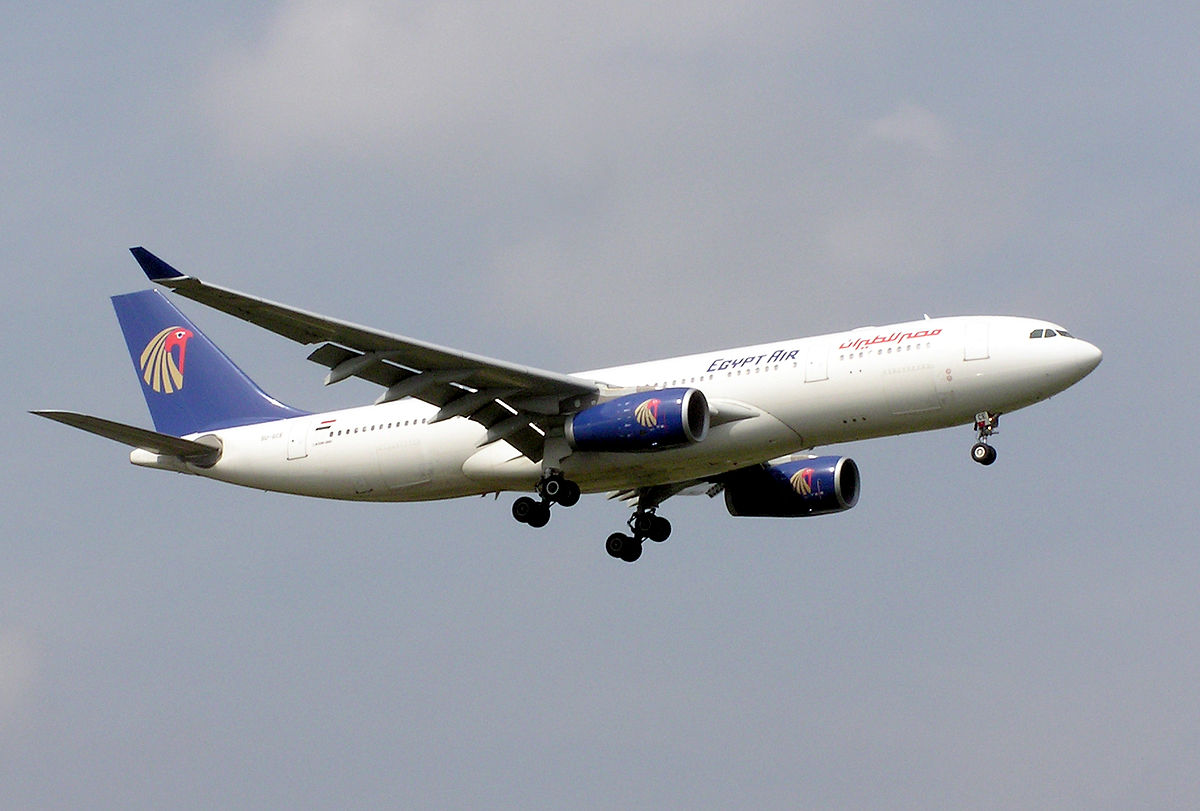

Top-5 similar images:
Image 1: Index 20550, Distance 124.65177066772442


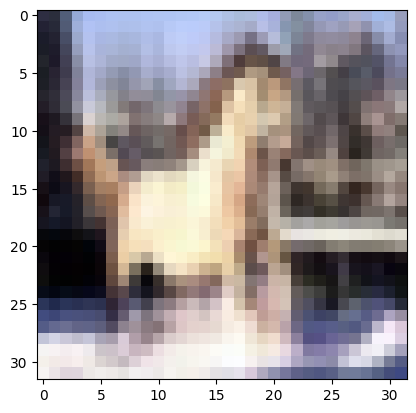

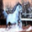

Image 2: Index 45857, Distance 124.741501173422


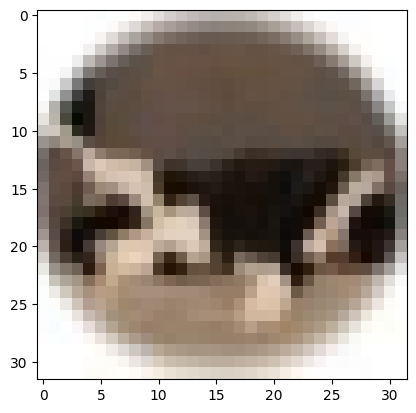

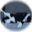

Image 3: Index 51145, Distance 124.80846299243424


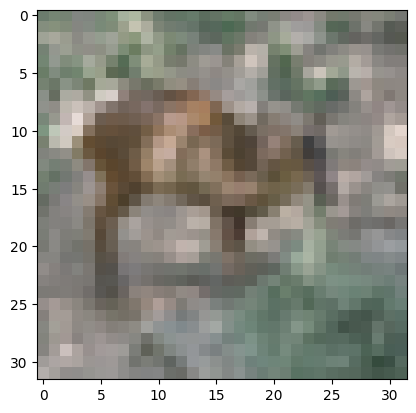

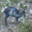

Image 4: Index 48828, Distance 124.8510928353052


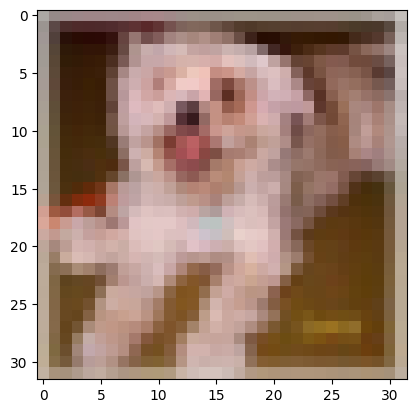

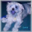

Image 5: Index 57323, Distance 125.00246711879781


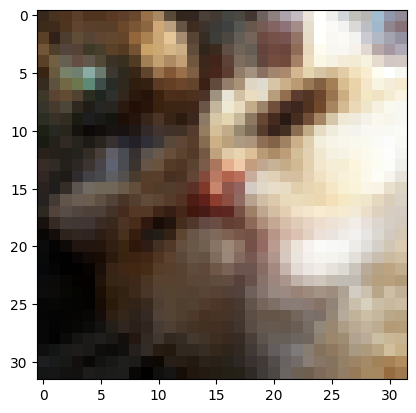

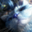

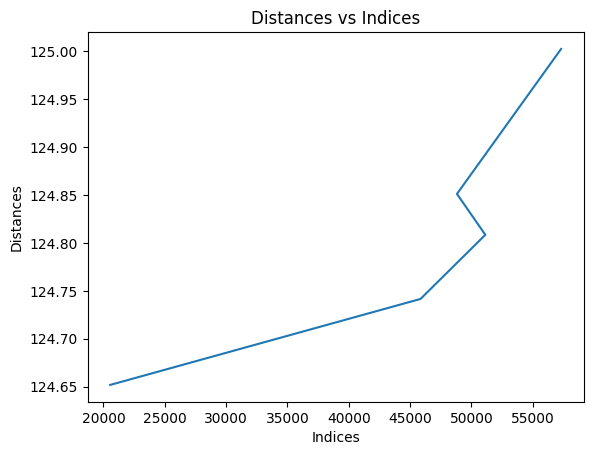

In [ ]:
from google.colab.patches import cv2_imshow
img= cv2.imread("/content/1200px-Egyptair.a330-200.su-gce.arp.jpg")
cv2_imshow(img)

image_search(img, 5)


**testing with an image from the dataset= image[654] (works perfectly)**

---



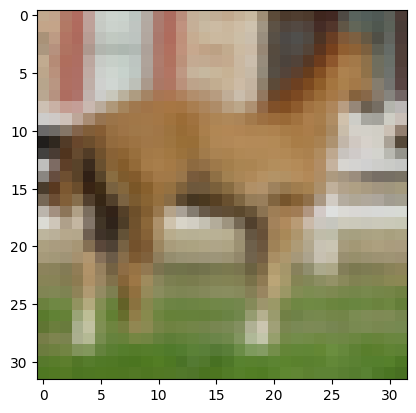

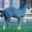

Top-5 similar images:
Image 1: Index 654, Distance 0.0


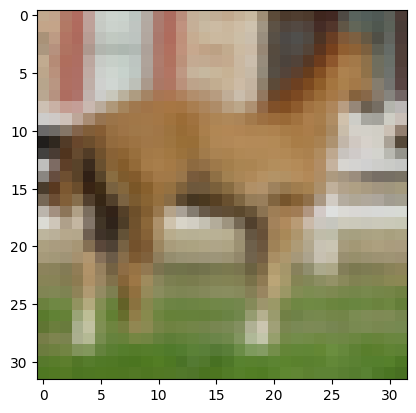

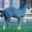

Image 2: Index 14825, Distance 0.33794352061667843


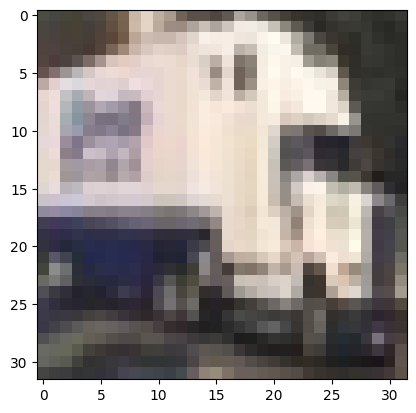

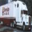

Image 3: Index 2905, Distance 0.58938719446187


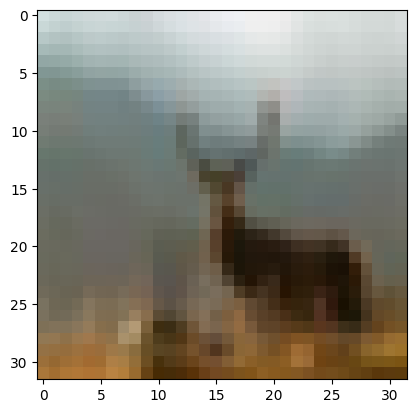

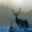

Image 4: Index 29111, Distance 0.8306592167525862


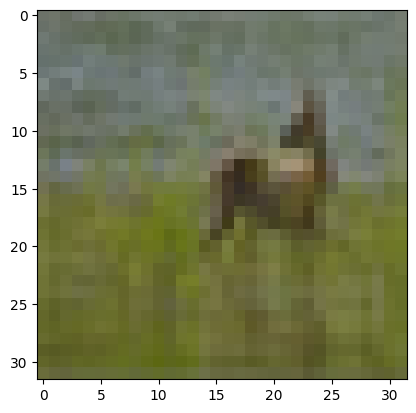

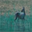

Image 5: Index 47032, Distance 0.8306592167525864


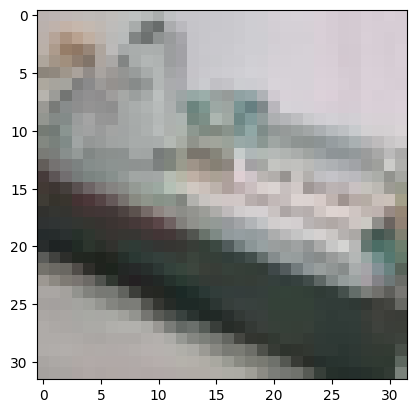

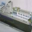

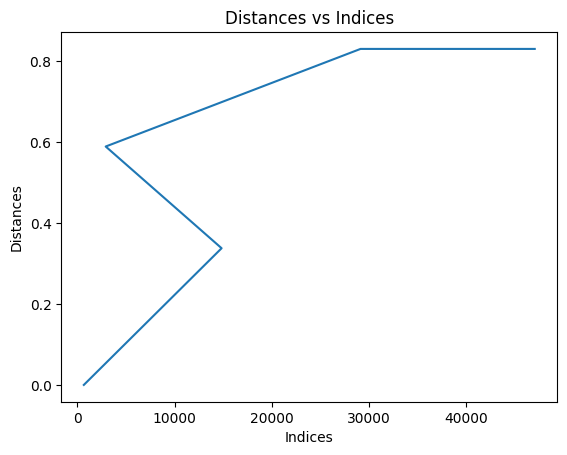

In [ ]:
import matplotlib.pyplot as plt
img_1= images[654]
plt.imshow(img_1)
plt.show()
cv2_imshow(img_1)
image_search_1(img_1, 5)